<a href="https://colab.research.google.com/github/BrMrtn/GoogleColab/blob/main/K%C3%A9pfeldolgoz%C3%A1s/khf6_L%C5%91lap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_1.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_2.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap2_1.bmp
!wget https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap2_2.bmp

--2024-12-06 17:59:15--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_1.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5070054 (4.8M) [image/bmp]
Saving to: ‘lolap1_1.bmp.2’

lolap1_1.bmp.2      100%[===================>]   4.83M  --.-KB/s    in 0.06s   

2024-12-06 17:59:15 (75.1 MB/s) - ‘lolap1_1.bmp.2’ saved [5070054/5070054]

--2024-12-06 17:59:15--  https://raw.githubusercontent.com/BrMrtn/GoogleColab/main/resources/lolap1_2.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5070054 (4.8M) 

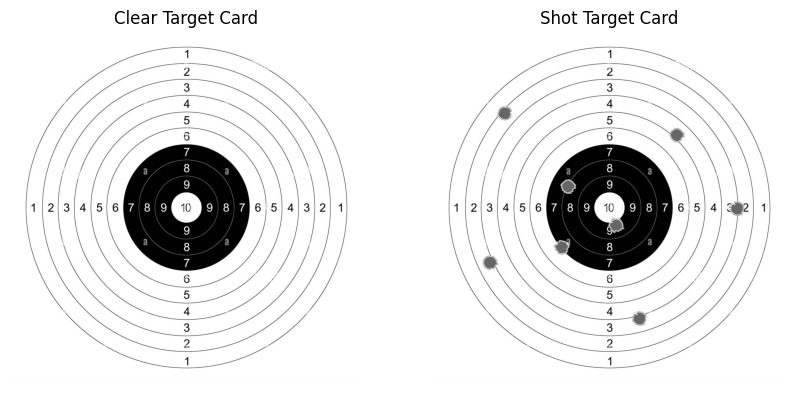

In [3]:
# Képek betöltése
target_card = cv2.imread('lolap1_1.bmp')
target_card_shot = cv2.imread('lolap1_2.bmp')

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(target_card, cv2.COLOR_BGR2RGB))
axs[0].set_title('Clear Target Card')
axs[1].imshow(cv2.cvtColor(target_card_shot, cv2.COLOR_BGR2RGB))
axs[1].set_title('Shot Target Card')
axs[0].axis('off'); axs[1].axis('off');

In [4]:
# Hough-transzformáció használatához konvertálás szürkeárnyalatossá
target_card = cv2.cvtColor(target_card, cv2.COLOR_BGR2GRAY)
target_card_shot = cv2.cvtColor(target_card_shot, cv2.COLOR_BGR2GRAY)

## Alapkörök megtalálása a lövések nélküli képen

Kis utánajárással kiderítettem, hogy a HoughCircles függvény nem képes koncentrikus köröket detektálni, ezért egyszerre csak egy kört keresek, és a paramétereket minden ciklusban állítom.

Bár nem szép, és nem univerzális megoldás, de:

Az alábbi módszerrel, kézzel tesztelve megállapítottam egy körülbelüli értéket a körök helyére. Ez persze nem biztos, hogy pontos, így van értelme a tényleges köröket ezután még Hough-transzformációval megkeresni.

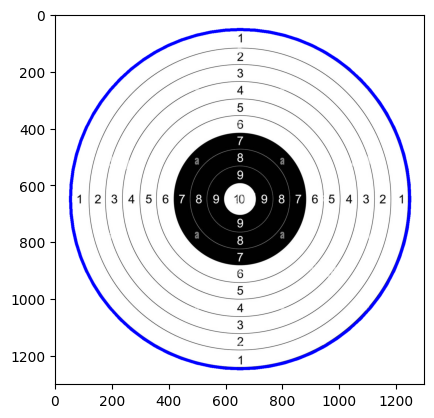

In [5]:
target_card_try = cv2.cvtColor(target_card, cv2.COLOR_GRAY2BGR) # Hogy színesen látszódjon a rárajzolt kör

center = (target_card_try.shape[1]//2, target_card_try.shape[0]//2)
inner_circle_width = 56 # Belső (fekete hátterű) gyűrűk közti távolság (illetve a belső kör sugara)
outer_circle_width = 62 # Külső gyűrűk közti távolság

cv2.circle(target_card_try, center, 4*inner_circle_width+6*outer_circle_width, (0, 0, 255), 10)

plt.imshow(target_card_try)

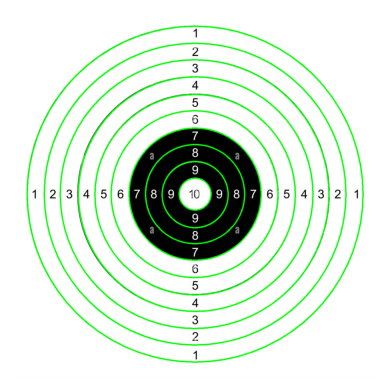

In [6]:
base_circles = []

# 10, 9, 8, 7-es körök detektálása
for i in range(1, 5):
  found_circles = cv2.HoughCircles(target_card, cv2.HOUGH_GRADIENT, 1, 1000, param1=200, param2=10, minRadius=i*inner_circle_width-10, maxRadius=i*inner_circle_width+10)
  found_circles = np.uint16(np.around(found_circles))
  base_circles.append(found_circles[0, 0]) # Ha több kört talált volna, vesszük a legelsőt

# A többi kör detektálása
radius0 = 4 * inner_circle_width
for i in range(1, 7):
  found_circles = cv2.HoughCircles(target_card, cv2.HOUGH_GRADIENT, 1, 1000, param1=200, param2=10, minRadius=radius0+i*outer_circle_width-10, maxRadius=radius0+i*outer_circle_width+10)
  found_circles = np.uint16(np.around(found_circles))
  base_circles.append(found_circles[0, 0])

# körök kirajzolása
target_card_with_base_circles = cv2.cvtColor(target_card, cv2.COLOR_GRAY2BGR)
for base_circle in base_circles:
  cv2.circle(target_card_with_base_circles, (base_circle[0], base_circle[1]), base_circle[2], (0, 255, 0), 4)

plt.axis('off')
plt.imshow(target_card_with_base_circles)

## Lövések megtalálása a képen

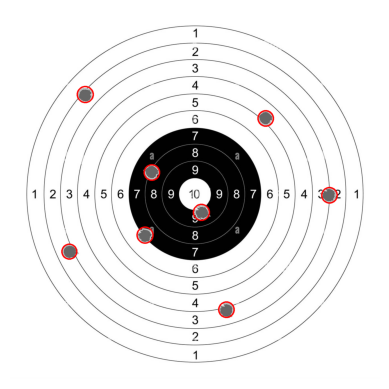

In [7]:
# A Hough transzformáció sajnos nagyon furcsa dolgokban is talál kört, ezért a paramétereket nagyon finoman kell állítgatni, hogy ne detektáljon hamisan.
found_hits = cv2.HoughCircles(target_card_shot, cv2.HOUGH_GRADIENT, 1, 200, param1=50, param2=10, minRadius=25, maxRadius=29)
found_hits = np.uint16(np.around(found_hits))
found_hits = found_hits[0, :]

target_card_with_hits = cv2.cvtColor(target_card_shot, cv2.COLOR_GRAY2BGR)
for hit in found_hits:
  cv2.circle(target_card_with_hits, (hit[0], hit[1]), hit[2], (255, 0, 0), 4)

plt.axis('off')
plt.imshow(target_card_with_hits)

## Pontszám meghatározása

In [8]:
# Találatok pontszámainak meghatározása
distances = []
points = []

for x, y, r in found_hits:
  distances.append(np.sqrt((x-center[0])**2 + (y-center[1])**2) - r)
  for i, base_circle in enumerate(base_circles): # Az alapkörök bentről kifele sorrenben szerepelnek a listában
    if distances[-1] <= base_circle[2]: # A kör érintése esetén már jár a pont
      points.append(10-i)
      break
  if (distances[-1] > base_circles[-1][2]):
    points.append(0)

print("Pontszámok egyesével: ", end="")
for point in points:
  print(point, end=" ")

score = sum(points)
print(f'\n\nÖsszpontszám: {score}')

Pontszámok egyesével: 3 5 3 8 7 10 2 4 

Összpontszám: 42
